##The data are measured each 30 min in one location by online water quality monitor system

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime
import warnings
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from livelossplot.keras import PlotLossesCallback

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras import Input, Model

from numpy import concatenate

from sklearn.metrics import mean_squared_error
from math import sqrt

%matplotlib inline
plt.rcParams['figure.figsize'] = (40, 70) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


Using TensorFlow backend.


In [28]:
#载入数据
dataset = pd.read_csv('HQQ.csv', header=0, index_col=None, parse_dates=True)


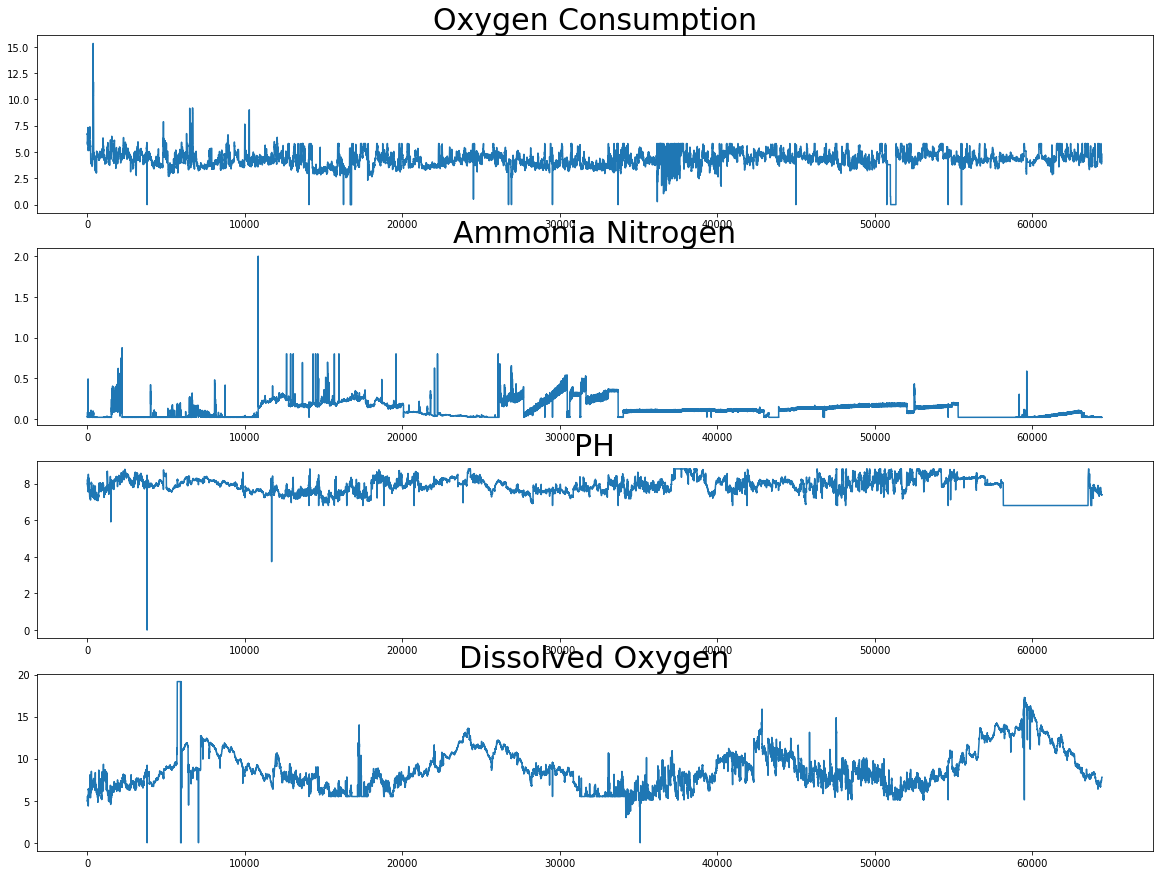

In [29]:
values = dataset.values
groups = [ 1, 2, 3, 4]
fig, axs = plt.subplots(1)
i = 1
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], fontsize=30)
    i+=1
plt.show()

## Data Preprocessing

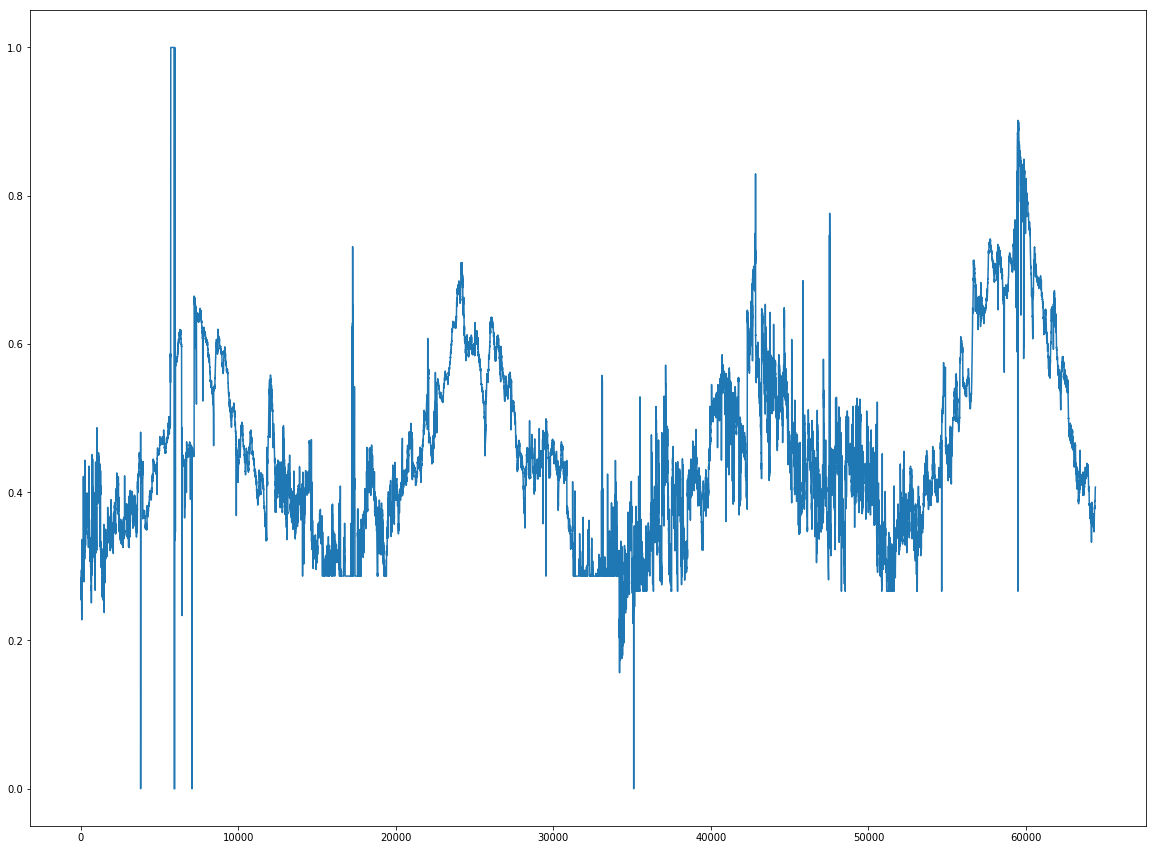

In [35]:
do=dataset['Dissolved Oxygen']
DO=[]
for i in range(0,len(do)):
        DO.append([do[i]])
scaler_DO = MinMaxScaler(feature_range=(0,1))
DO = scaler_DO.fit_transform(DO)
plt.rcParams['figure.figsize'] = (20, 15)
plt.plot(DO)

In [7]:
from tcn import TCN

In [8]:
def data_split_TCN(data, train_len, lookback_window):
    train=data[:train_len]
    test=data[train_len:]
    X1, y1=[], []
    for i in range(lookback_window, len(train)):
        X1.append(train[i - lookback_window:i])
        y1.append(train[i])
        y_train = np.array(y1)
        X_train = np.array(X1)

    X2, y2=[], []
    for i in range(lookback_window, len(test)):
        X2.append(test[i - lookback_window:i])
        y2.append(test[i])
        y_test = np.array(y2)
        X_test = np.array(X2)
    
    return (X_train, y_train, X_test, y_test)

In [9]:
def data_split_LSTM(X_train,y_train, X_test, y_test, lookback_windows): #data split for LSTM is also fit to GRU
    # reshape the data to satisfy the input acquirement of LSTM
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    y_train = y_train.reshape(y_train.shape[0], 1)
    y_test = y_test.reshape(y_test.shape[0], 1)
    
    return (X_train, y_train, X_test, y_test)

In [10]:
#Visualization
def visualize(history):
    plt.rcParams['figure.figsize'] = (10.0, 6.0)
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [23]:
def TCN_Model(X_train, y_train, lookback_window):
    i = Input(shape=(lookback_window, 1))
    m = TCN()(i)
    m = Dense(1, activation='linear')(m)
    model = Model(inputs=[i], outputs=[m])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=5, validation_split=0.2, shuffle=True, verbose=1)
    return (model)

In [24]:
def LSTM_Model(X_train, y_train):
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    model.fit(X_train, y_train, epochs=5,  batch_size=20,  validation_split=0.2, verbose=1, shuffle=True) 
    return(model)
#batch_size=1 has the best result, but its disadvantage is it needs much longer time

In [25]:
def GRU_Model(X_train, y_train):
    model = Sequential()
    model.add(GRU(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    model.fit(X_train, y_train, epochs=5,  batch_size=20,  validation_split=0.2, verbose=1, shuffle=True)
    return(model)

In [26]:
c=int(len(DO)*.8)

In [27]:
X1_train, y1_train, X1_test, y1_test =data_split_TCN(DO, c, 20) #TCN
X2_train, y2_train, X2_test, y2_test = data_split_LSTM(X1_train, y1_train, X1_test, y1_test, 20)  #LSTM
X3_train, y3_train, X3_test, y3_test = data_split_LSTM(X1_train, y1_train, X1_test, y1_test, 20)  #GRU

In [31]:
model_DO_TCN=TCN_Model(X1_train, y1_train, 20)

Instructions for updating:
Use tf.cast instead.
Train on 33003 samples, validate on 8251 samples
Epoch 1/5
33003/33003 [==============================] - 55s 2ms/step - loss: 0.0842 - val_loss: 7.4444e-04
Epoch 2/5
33003/33003 [==============================] - 52s 2ms/step - loss: 6.8832e-04 - val_loss: 8.4124e-04
Epoch 3/5
33003/33003 [==============================] - 52s 2ms/step - loss: 7.2783e-04 - val_loss: 6.8676e-04
Epoch 4/5
33003/33003 [==============================] - 53s 2ms/step - loss: 7.8189e-04 - val_loss: 6.0065e-04
Epoch 5/5
33003/33003 [==============================] - 55s 2ms/step - loss: 0.0773 - val_loss: 8.2093e-04


In [32]:
model_DO_LSTM=LSTM_Model(X2_train, y2_train)

Train on 33003 samples, validate on 8251 samples
Epoch 1/5
33003/33003 [==============================] - 56s 2ms/step - loss: 8.8916e-04 - val_loss: 6.2968e-04
Epoch 2/5
33003/33003 [==============================] - 54s 2ms/step - loss: 1.7433e-04 - val_loss: 4.5061e-04
Epoch 3/5
33003/33003 [==============================] - 53s 2ms/step - loss: 1.3872e-04 - val_loss: 3.6204e-04
Epoch 4/5
33003/33003 [==============================] - 53s 2ms/step - loss: 1.1838e-04 - val_loss: 3.0854e-04
Epoch 5/5
33003/33003 [==============================] - 54s 2ms/step - loss: 1.0772e-04 - val_loss: 2.7739e-04


In [33]:
model_DO_GRU=GRU_Model(X3_train, y3_train)

Train on 33003 samples, validate on 8251 samples
Epoch 1/5
33003/33003 [==============================] - 42s 1ms/step - loss: 8.4668e-04 - val_loss: 3.2459e-04
Epoch 2/5
33003/33003 [==============================] - 44s 1ms/step - loss: 1.0936e-04 - val_loss: 2.9206e-04
Epoch 3/5
33003/33003 [==============================] - 45s 1ms/step - loss: 1.0684e-04 - val_loss: 2.7488e-04
Epoch 4/5
33003/33003 [==============================] - 44s 1ms/step - loss: 1.0246e-04 - val_loss: 2.7039e-04
Epoch 5/5
33003/33003 [==============================] - 44s 1ms/step - loss: 1.0472e-04 - val_loss: 2.6736e-04


In [36]:
#TCN original data 
y1_train_hat=model_DO_TCN.predict(X1_train)
y1_train_hat=scaler_DO.inverse_transform(y1_train_hat)
y1_train=scaler_DO.inverse_transform(y1_train)

y1_test_hat=model_DO_TCN.predict(X1_test)
y1_test_hat=scaler_DO.inverse_transform(y1_test_hat)
y1_test=scaler_DO.inverse_transform(y1_test)



In [37]:
def plot_curve(true_data, predicted):
 
    plt.plot(true_data, label='True data')
    plt.plot(predicted, label='Predicted data')
    #plt.plot(predicted_LSTM, label='Predicted data by LSTM')
    plt.legend()
    plt.savefig('result.png')
    plt.show()



## TCN

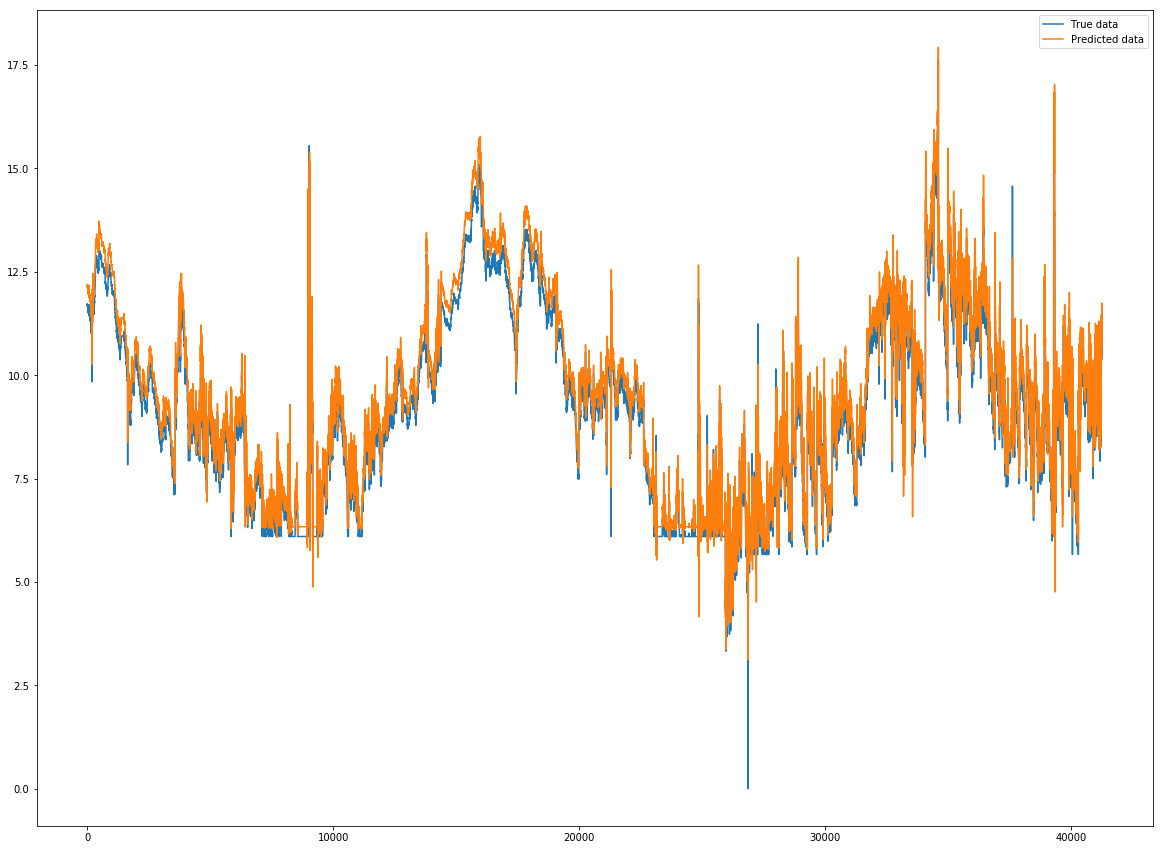

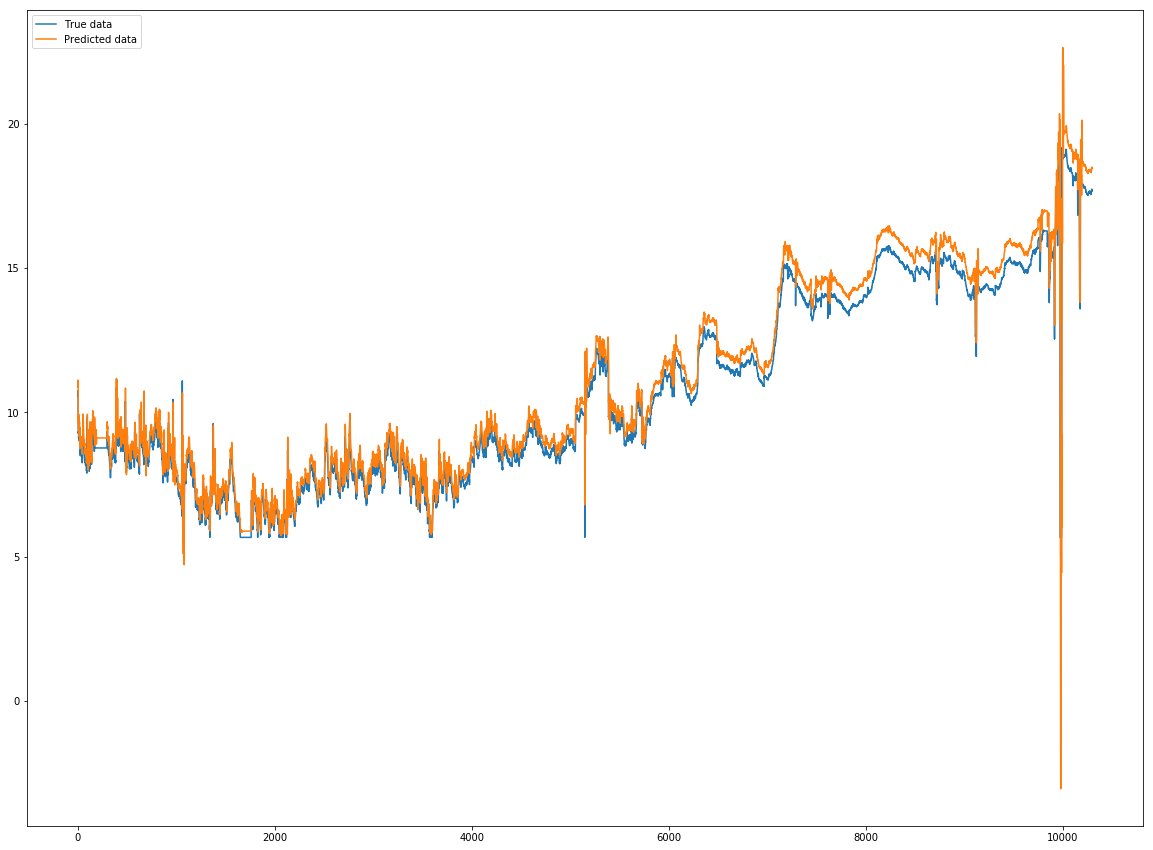

In [38]:
plot_curve(y1_train, y1_train_hat)
plot_curve(y1_test, y1_test_hat)

## LSTM

In [39]:
y2_train_hat=model_DO_LSTM.predict(X2_train)
y2_train_hat=scaler_DO.inverse_transform(y2_train_hat)
y2_train=scaler_DO.inverse_transform(y2_train)

y2_test_hat=model_DO_LSTM.predict(X2_test)
y2_test_hat=scaler_DO.inverse_transform(y2_test_hat)
y2_test=scaler_DO.inverse_transform(y2_test)

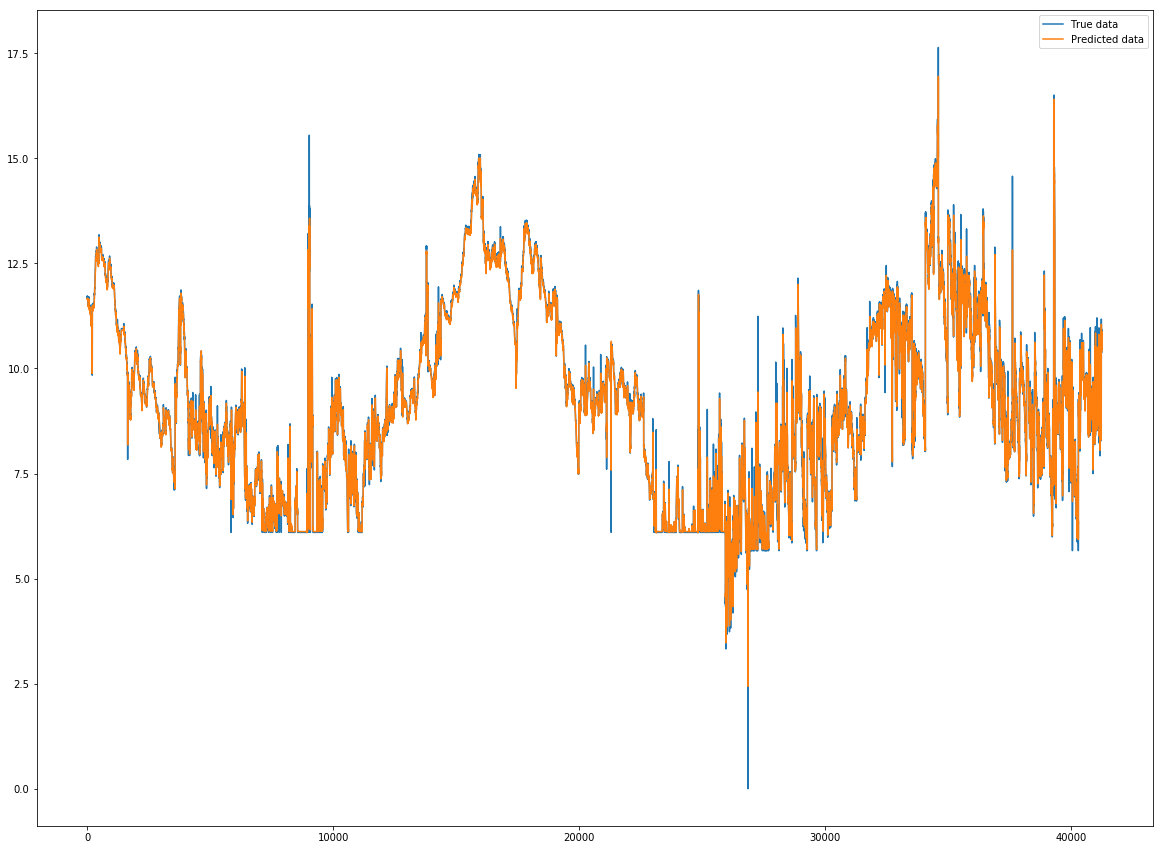

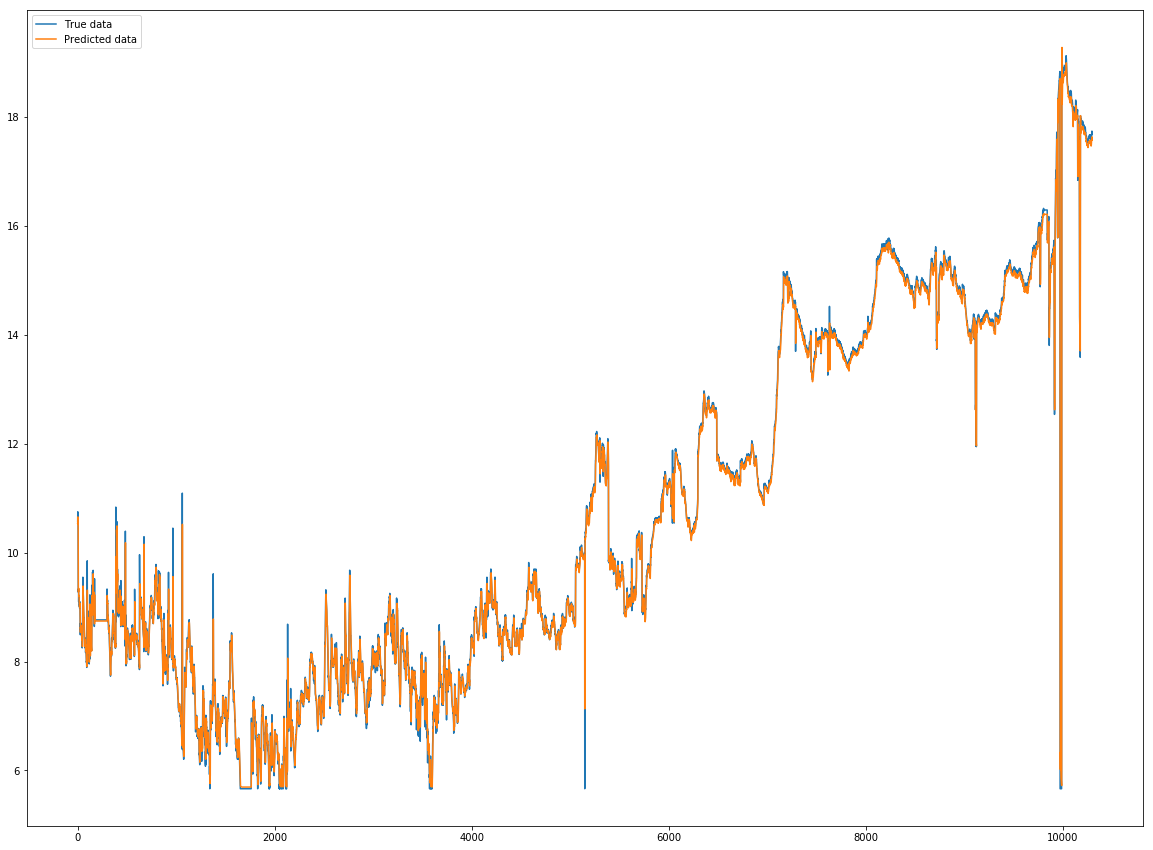

In [40]:
plot_curve(y2_train, y2_train_hat)
plot_curve(y2_test, y2_test_hat)

## GRU

In [41]:
y3_train_hat=model_DO_GRU.predict(X3_train)
y3_train_hat=scaler_DO.inverse_transform(y3_train_hat)
y3_train=scaler_DO.inverse_transform(y3_train)

y3_test_hat=model_DO_GRU.predict(X3_test)
y3_test_hat=scaler_DO.inverse_transform(y3_test_hat)
y3_test=scaler_DO.inverse_transform(y3_test)

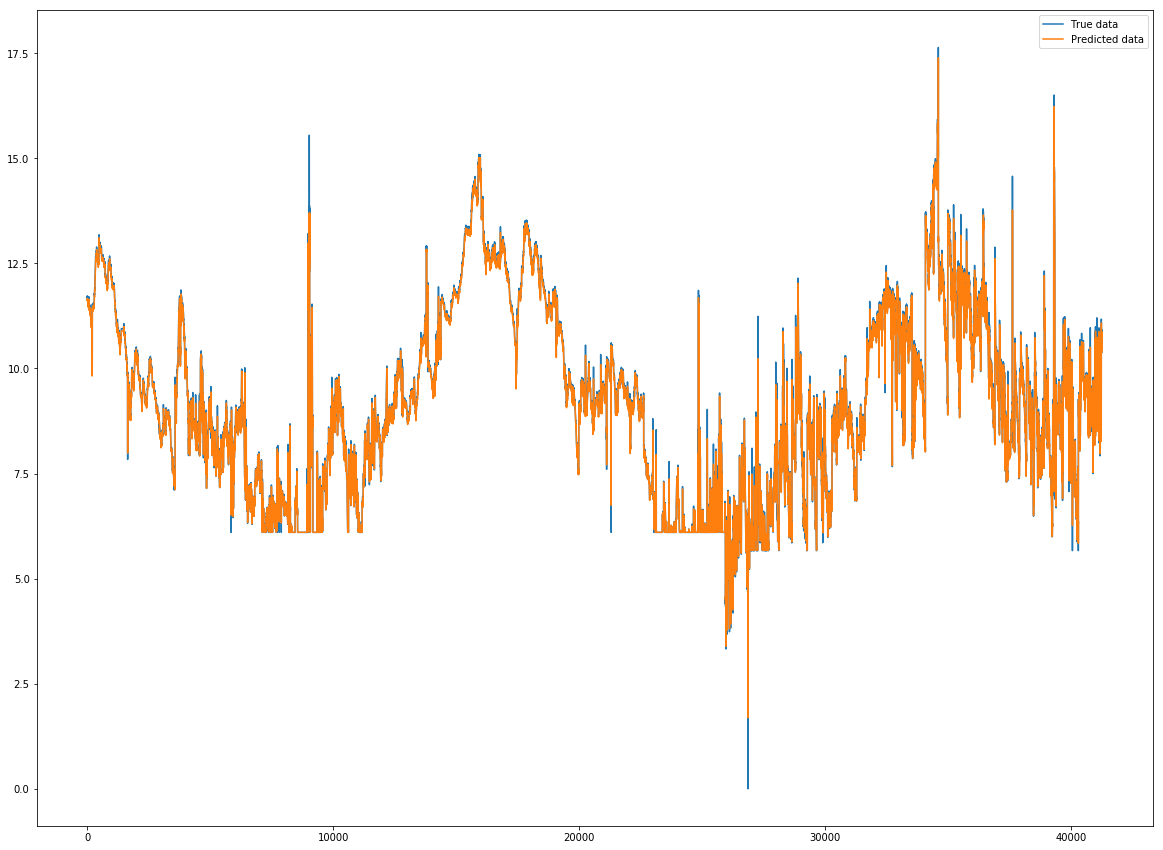

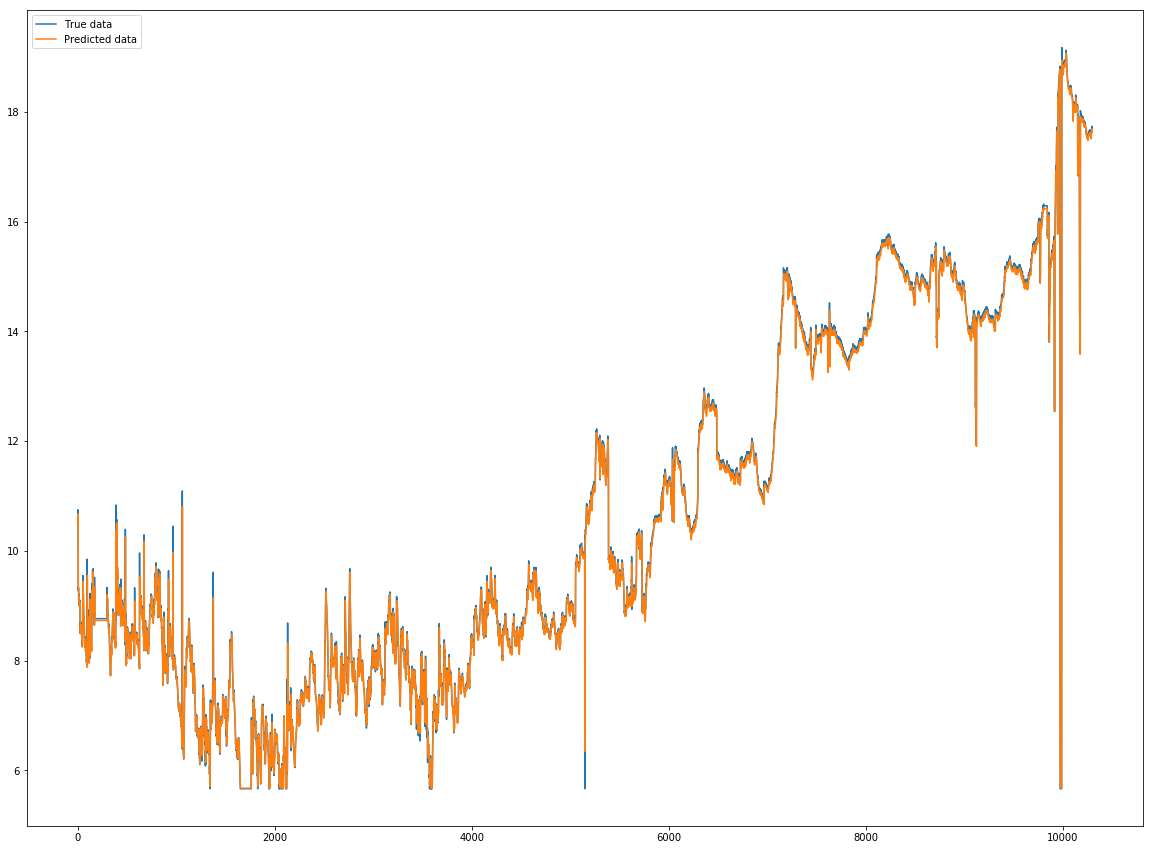

In [42]:
plot_curve(y3_train, y3_train_hat)
plot_curve(y3_test, y3_test_hat)